From 03_signal_simulation_range.ipynb, we generate out a raw data of a SAR.

In [1]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, FloatSlider, IntSlider
from scipy.signal import chirp

In [2]:
def generate_chirp(start_time=0,
                    pulse_width=1.0,
                    amplitude=1.0,
                    frequency=100_000.0,
                    bandwidth=1_000,
                    sampling_frequency=1_000_000):
    """
    Generate a chirp waveform starting from 0 to pulse_width (duration only), ignoring start_time offset.
    
    Returns the chirp waveform (1D array) only — timing managed at insertion level.
    """
    num_chirp_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(0, pulse_width, num_chirp_samples, endpoint=False)
    
    gamma = bandwidth / pulse_width
    phase = 2 * np.pi * frequency * t + np.pi * gamma * (t - pulse_width / 2) ** 2
    chirp = amplitude * np.sin(phase)
    
    return chirp


def _generate_single_chirp(args):
    """
    Generates only the active chirp segment and its insertion index.
    """
    i, PRI, delay, pulse_width, bandwidth, frequency, sampling_frequency = args

    start_index = int(delay * sampling_frequency)
    chirp = generate_chirp(
        pulse_width=pulse_width,
        amplitude=1.0,
        frequency=frequency,
        bandwidth=bandwidth,
        sampling_frequency=sampling_frequency
    )

    if i % 10 == 0:
        print(f"i = {i}, start_index = {start_index}, chirp_length = {len(chirp)}, delay = {delay:.6f}s")

    return (i, start_index, chirp)


def calculate_integration_angle(K_a = 1.2, wavelength = 0.03, azimuth_resolution = 1.0):
    """
    Calculate the satellite integration angle based on the given parameters.
    
    Parameters:
    K_a (float): Broadening Factor of azimuth resoluion to compensate for window filtering, default is 1.2.
    wavelength (float): Wavelength of the signal in meters, default is 0.03.
    azimuth_resolution (float): Desired azimuth resolution in meters, default is 1.0.
    
    Returns:
    float: The calculated integration angle in radians.
    """
    integration_angle = (K_a * wavelength) / (2 * azimuth_resolution)
    return integration_angle


def simulate_sar_raw_data_threaded(num_of_samples, time_result, PRI,
                                   pulse_width=1.0, bandwidth=1_000.0, frequency=100_000.0,
                                   sampling_frequency=1_000_000):
    """
    Efficient SAR raw data simulator using only the windowed active chirp region.
    """

    # Determine how long the full signal buffer should be based on max delay + pulse width
    max_delay = max(time_result)
    total_duration = max_delay + pulse_width + pulse_width # Add extra pulse width to see end
    num_time_samples = int(np.ceil(total_duration * sampling_frequency))
    print(f"[INFO] Total fast-time samples allocated per row: {num_time_samples}")

    # Allocate zeroed raw data array
    raw_data = np.zeros((num_of_samples, num_time_samples), dtype=np.float32)

    # Package arguments
    args_list = [
        (i, PRI, time_result[i], pulse_width, bandwidth, frequency, sampling_frequency)
        for i in range(int(num_of_samples))
    ]

    # Threaded chirp generation
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(_generate_single_chirp, args_list))

    # Insert chirps at the right start index
    for i, start_index, chirp in results:
        end_index = start_index + len(chirp)
        if end_index <= raw_data.shape[1]:
            raw_data[i, start_index:end_index] = chirp
        else:
            # Trim if chirp would overflow the buffer
            valid_len = raw_data.shape[1] - start_index
            if valid_len > 0:
                raw_data[i, start_index:] = chirp[:valid_len]

    return raw_data

def plot_raw_sar_data(raw_data, sampling_frequency, time_result=None,
                      xlim_microseconds=None, downsample_fast=10, downsample_slow=1, show_delay=True):
    """
    Efficient visualisation of raw SAR data with downsampling.
    
    Parameters:
    - raw_data: 2D array (num_pulses, num_samples)
    - sampling_frequency: Hz
    - time_result: optional list of time delays (seconds)
    - xlim_microseconds: tuple (xmin, xmax) to limit x-axis
    - downsample_fast: downsample factor along fast time
    - downsample_slow: downsample factor along pulse index
    - show_delay: whether to plot slant range time delays
    """

    # Downsample both fast and slow time
    raw_data_ds = raw_data[::downsample_slow, ::downsample_fast].astype(np.float32)
    ds_fs = sampling_frequency / downsample_fast

    num_pulses, num_samples = raw_data_ds.shape
    fast_time_us = np.linspace(0, num_samples / ds_fs * 1e6, num_samples)
    pulse_indices = np.arange(0, raw_data.shape[0], downsample_slow)

    print(f"[INFO] Plotting {num_pulses} pulses, {num_samples} samples per pulse (downsampled)")
    print(f"[INFO] Fast time: {fast_time_us[0]:.2f}–{fast_time_us[-1]:.2f} μs")

    # Heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(raw_data_ds, aspect='auto',
               extent=[fast_time_us[0], fast_time_us[-1], pulse_indices[-1], pulse_indices[0]],
               cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Amplitude")
    plt.xlabel("Fast Time (μs)")
    plt.ylabel("Pulse Index (Slow Time)")
    plt.title("Simulated Raw SAR Data")

    if xlim_microseconds:
        plt.xlim(xlim_microseconds)

    plt.tight_layout()
    plt.show()

    # Optional: Slant Range Delay Plot
    if show_delay and time_result is not None:
        plt.figure(figsize=(8, 3))
        time_us = np.array(time_result) * 1e6
        plt.plot(np.arange(len(time_us)), time_us, linewidth=1)
        plt.xlabel("Pulse Index")
        plt.ylabel("Time Delay (μs)")
        plt.title("Slant Range Time Delays")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def simulate_time_result(light_speed: float = 3e8, 
                         azimuth_length: float = 100.0, 
                         range_width: float = 100.0, 
                         sensor_speed: float = 100.0, 
                         grazing_angle_deg: float = 40.0,
                         integration_angle_rad: float = 20.0,
                         sensor_height: float = 10000.0,
                         max_capturable_height: float = 0,
                         sampling_frequency: float = 2000,
                         PRF: float = 100,
                         target_x: float = 0,
                         target_y: float = 0,
                         target_z: float = 0):

    # Derived parameters
    grazing_angle_rad = math.radians(grazing_angle_deg)

    h = sensor_height
    v = sensor_speed
    L = azimuth_length
    B = range_width
    C = light_speed
    max_h = max_capturable_height
    x_t, y_t, z_t = target_x, target_y, target_z
    PRI = 1 / PRF

    y_c = h / math.tan(grazing_angle_rad)   # Horizontal distance to the origin of target strip

    delta_max = y_c * math.tan(0.5 * integration_angle_rad)         # Maximum positive distance deviation from APC

    num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

    # Function to calculate distance deviation of current sensor based on sample index
    cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

    # Function to calculate slant distance of the target from the current sensor position
    # cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   
    cal_target_slant_distance = lambda dist_deviation: math.sqrt(
        (h - z_t)**2 +
        (dist_deviation - x_t)**2 +
        (y_c - y_t)**2
    )   

    # Assume that the distance deviation of sensor when it emit and receive signal is neglible
    cal_time_pulse = lambda distance : (2 *distance) / C

    time_result = []

    for i in range(math.floor(num_of_samples)):
        dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
        target_slant_distance = cal_target_slant_distance(dist_deviation)   
        time_pulse = cal_time_pulse(target_slant_distance)
        time_result.append(time_pulse)
        if i in [0, math.floor(num_of_samples) // 2]:
            print(f"Sample {i}: Distance Deviation = {dist_deviation:.5f} m, Slant Distance = {target_slant_distance:.2f} m, Time Pulse = {time_pulse:.6f} s, delta_max = {delta_max:.2f} m")

    time_result = np.array(time_result)
    print(time_result[:10]*1e6)

    return time_result

Integration angle: 0.0360 degrees
Sample 0: Distance Deviation = -2145.38817 m, Slant Distance = 163810.21 m, Time Pulse = 0.001092 s, delta_max = 2145.39 m
Sample 286: Distance Deviation = -0.38817 m, Slant Distance = 163665.15 m, Time Pulse = 0.001091 s, delta_max = 2145.39 m
[1092.06804618 1092.06434017 1092.06063643 1092.05693497 1092.05323579
 1092.04953888 1092.04584425 1092.0421519  1092.03846182 1092.03477402]
Time taken to simulate time result: 0.55 milliseconds
Min delay: 1090.32306 μs
Max delay: 1092.06805 μs
Total shift: 1.74 μs
[INFO] Total fast-time samples allocated per row: 1102069
i = 0, start_index = 1092068, chirp_length = 5000, delay = 0.001092s
i = 10, start_index = 1092031, chirp_length = 5000, delay = 0.001092s
i = 20, start_index = 1091994, chirp_length = 5000, delay = 0.001092s
i = 40, start_index = 1091921, chirp_length = 5000, delay = 0.001092s
i = 30, start_index = 1091957, chirp_length = 5000, delay = 0.001092s
i = 50, start_index = 1091885, chirp_length = 

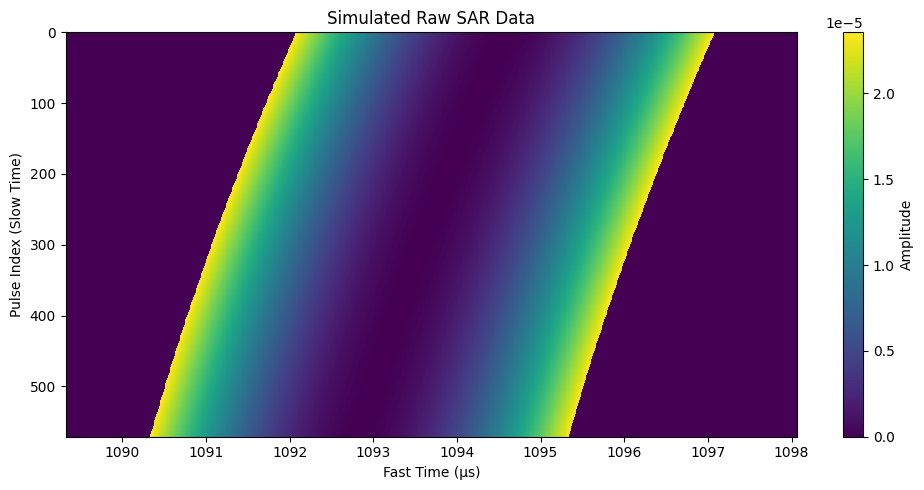

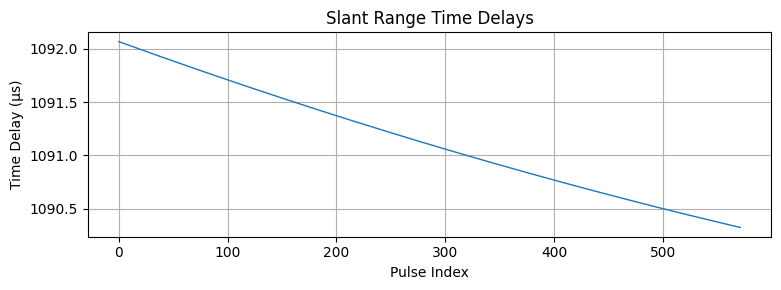

Time taken to plot raw SAR data: 4588.56 milliseconds


In [3]:
import time

radar_bands = {
    "L-band": {
        "frequency_range_GHz": (1.0, 2.0),
        "wavelength_cm": 3e10 / (1.5 * 1e9),  # ≈ 20.0 cm
        "application": "Air traffic control, ALOS-2 SAR"
    },
    "S-band": {
        "frequency_range_GHz": (2.0, 4.0),
        "wavelength_cm": 3e10 / (3.0 * 1e9),  # ≈ 10.0 cm
        "application": "Weather radar, marine radar"
    },
    "C-band": {
        "frequency_range_GHz": (4.0, 8.0),
        "wavelength_cm": 3e10 / (6.0 * 1e9),  # ≈ 5.0 cm
        "application": "Sentinel-1 SAR, meteorology"
    },
    "X-band": {
        "frequency_range_GHz": (8.0, 12.0),
        "wavelength_cm": 3e10 / (10.0 * 1e9),  # ≈ 3.0 cm
        "application": "High-res SAR (e.g., TerraSAR-X)"
    }
}

# Requested resolution
azimuth_resolution = 0.5
sampling_frequency = 1_000_000_000  # Hz
PRF = 1000  # Pulse Repetition Frequency in Hz
wavelength = radar_bands["X-band"]["wavelength_cm"] * 0.01  # Convert cm to m

integration_angle = calculate_integration_angle(K_a=1.2, wavelength=wavelength, azimuth_resolution=azimuth_resolution)
print(f"Integration angle: {integration_angle:.4f} degrees")

start_time = time.time_ns() * 10**-6  # Convert to milliseconds
time_result = simulate_time_result(
    integration_angle_rad=integration_angle,
    grazing_angle_deg=40.0,
    sensor_speed=7500.0,
    azimuth_length=50_000.0,
    range_width=50_000.0,
    sensor_height=100_000.0,
    PRF=PRF,
    max_capturable_height=0,
    sampling_frequency=sampling_frequency,
    target_x=10_000.0,
    target_y=-10_000.0,
    target_z=0.0
)
time_result_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to simulate time result: {time_result_time - start_time:.2f} milliseconds")
delays_us = np.array(time_result) * 1e6
print(f"Min delay: {delays_us.min():.5f} μs")
print(f"Max delay: {delays_us.max():.5f} μs")
print(f"Total shift: {(delays_us.max() - delays_us.min()):.2f} μs")


raw_data = simulate_sar_raw_data_threaded(
    num_of_samples=len(time_result),
    time_result=time_result,
    PRI=1/PRF,
    pulse_width=0.000005,
    bandwidth=6.0,
    frequency=3e8/wavelength,
    sampling_frequency=sampling_frequency
)

raw_data_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to simulate raw SAR data: {raw_data_time - time_result_time:.2f} milliseconds")

# Find non-zero energy indices for xlim suggestion
energy = np.abs(raw_data).max(axis=0)
nonzero_indices = np.where(energy > 0.0)[0]

if len(nonzero_indices) > 0:
    start_us = nonzero_indices[0] / sampling_frequency * 1e6
    end_us = nonzero_indices[-1] / sampling_frequency * 1e6
    print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    plot_raw_sar_data(
        raw_data, 
        sampling_frequency, 
        time_result, 
        xlim_microseconds=(start_us-1, end_us+1), 
        downsample_fast=10,
        downsample_slow=1
        )
else:
    print("No significant signal detected.")

plotting_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to plot raw SAR data: {plotting_time - raw_data_time:.2f} milliseconds")


In the following, we will now process our SAR raw data signals into a band usable for image formation. First, notice that the above Simulated Raw SAR Data yields a quadratic time shift pulse. We need to shift each of these signals to the start time window in the fast time. That is, we need to shift all the wave points to the left most axis, and we will obtain a vertical signal. As to which wave to centre, we usually pick the centre of our image as the reference (x=0, y=0, z=0).

Sample 0: Distance Deviation = -2145.38817 m, Slant Distance = 155587.17 m, Time Pulse = 0.001037 s, delta_max = 2145.39 m
Sample 286: Distance Deviation = -0.38817 m, Slant Distance = 155572.38 m, Time Pulse = 0.001037 s, delta_max = 2145.39 m
[1037.24783163 1037.24714339 1037.24645755 1037.24577413 1037.24509311
 1037.24441451 1037.24373831 1037.24306453 1037.24239315 1037.24172419]
Sample 0: Distance Deviation = -2145.38817 m, Slant Distance = 148548.88 m, Time Pulse = 0.000990 s, delta_max = 2145.39 m
Sample 286: Distance Deviation = -0.38817 m, Slant Distance = 148388.90 m, Time Pulse = 0.000989 s, delta_max = 2145.39 m
[990.3258616  990.32177484 990.31769059 990.31360885 990.30952961
 990.30545289 990.30137867 990.29730696 990.29323776 990.28917106]
[INFO] Total fast-time samples allocated per row: 1000326
i = 0, start_index = 990325, chirp_length = 5000, delay = 0.000990s
i = 10, start_index = 990285, chirp_length = 5000, delay = 0.000990s
i = 30, start_index = 990204, chirp_len

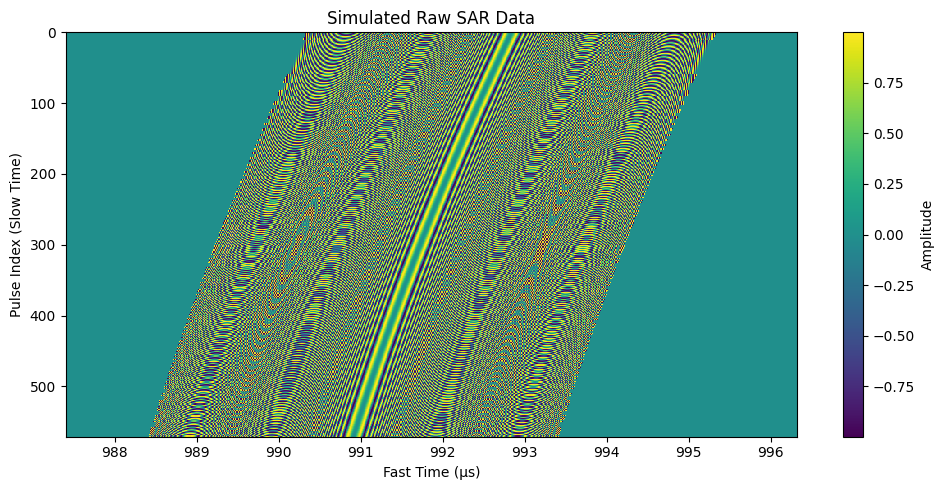

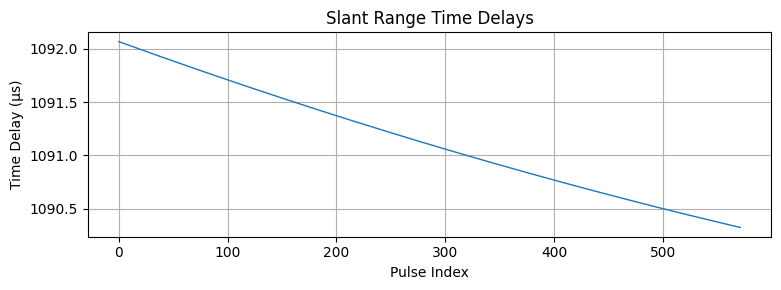

[INFO] Total fast-time samples allocated per row: 10000
i = 0, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 10, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 20, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 30, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 40, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 50, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 60, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 70, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 80, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 90, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 100, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 110, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 120, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 140, start_index = 0, chirp_length = 5000, delay = 0.000000s
i = 150, start_index = 0, chirp_length = 5000

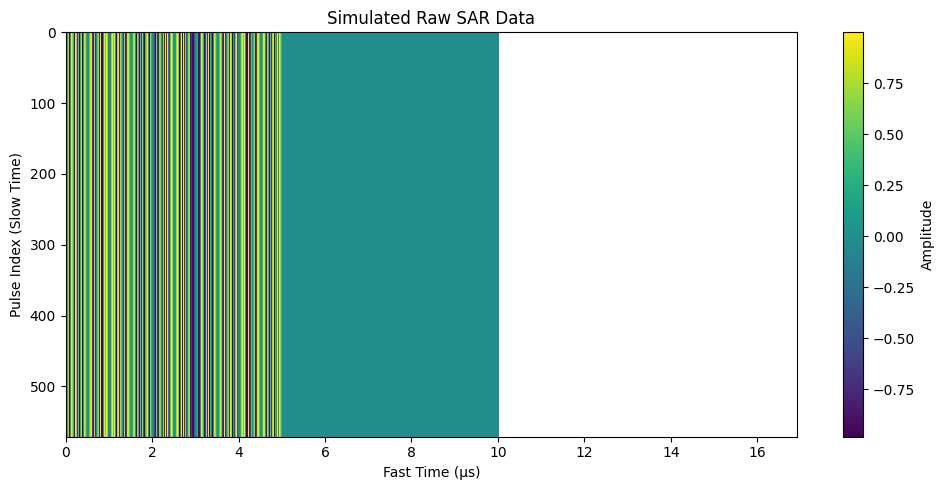

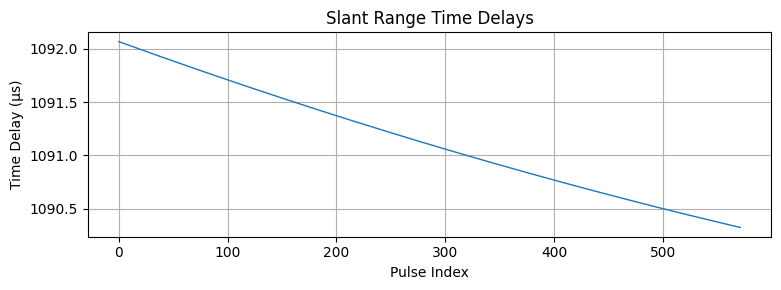

In [73]:
# Requested resolution
azimuth_resolution = 0.5
sampling_frequency = 1_000_000_000  # Hz
PRF = 1000  # Pulse Repetition Frequency in Hz
wavelength = radar_bands["X-band"]["wavelength_cm"] * 0.01  # Convert cm to m

integration_angle = calculate_integration_angle(K_a=1.2, wavelength=wavelength, azimuth_resolution=azimuth_resolution)

grazing_angle_deg=40.0
sensor_speed=7500.0
azimuth_length=50_000.0
range_width=50_000.0
sensor_height=100_000.0
PRF=PRF
max_capturable_height=0
pulse_width=0.000005  # 5 microseconds
bandwidth=500_000_000 
target_x = 10_000.0
target_y = 10_000.0
target_z = 0.0


time_result_ref = simulate_time_result(
    target_x=0,
    target_y=0,
    target_z=0,
    integration_angle_rad=integration_angle,
    grazing_angle_deg=grazing_angle_deg,
    sensor_speed=sensor_speed,
    azimuth_length=azimuth_length,
    range_width=range_width,
    sensor_height=sensor_height,
    PRF=PRF,
    max_capturable_height=max_capturable_height,
    sampling_frequency=sampling_frequency,
)

time_result_target = simulate_time_result(
    integration_angle_rad=integration_angle,
    grazing_angle_deg=grazing_angle_deg,
    sensor_speed=sensor_speed,
    azimuth_length=azimuth_length,
    range_width=range_width,
    sensor_height=sensor_height,
    PRF=PRF,
    max_capturable_height=max_capturable_height,
    sampling_frequency=sampling_frequency,
    target_x=target_x,
    target_y=target_y,
    target_z=target_z
)

# Simulate raw data for the target
raw_data = simulate_sar_raw_data_threaded(
    num_of_samples=len(time_result_target),
    time_result=time_result_target,
    PRI=1/PRF,
    pulse_width=pulse_width,
    bandwidth=bandwidth,
    frequency=3e8/wavelength,
    sampling_frequency=sampling_frequency
)
# Find non-zero energy indices for xlim suggestion (PLOT raw data before alignment)
energy = np.abs(raw_data).max(axis=0)
nonzero_indices = np.where(energy > 0.0)[0]

if len(nonzero_indices) > 0:
    start_us = nonzero_indices[0] / sampling_frequency * 1e6
    end_us = nonzero_indices[-1] / sampling_frequency * 1e6
    print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    # Plot raw data
    plot_raw_sar_data(
        raw_data, 
        sampling_frequency, 
        time_result, 
        xlim_microseconds=(start_us-1, end_us+1), 
        downsample_fast=10,
        downsample_slow=1
        )
else:
    print("No significant signal detected.")

# Get start and end window intervals for alignment
window_us = (end_us + 5) - (start_us - 5)

centre_offset_sec = (window_us / 2) * 1e-6  # Convert to seconds
time_aligned = time_result_target - time_result_ref + centre_offset_sec
time_aligned = np.clip(time_aligned, 0, None)

raw_data_delayed = simulate_sar_raw_data_threaded(
    num_of_samples=len(time_result_target),
    time_result=time_aligned,  # Align to the centre of the window
    PRI=1/PRF,
    pulse_width=pulse_width,
    bandwidth=bandwidth,
    frequency=3e8/wavelength,
    sampling_frequency=sampling_frequency
)

# Visualise
# Find non-zero energy indices for xlim suggestion (PLOT aligned data)
energy = np.abs(raw_data_delayed).max(axis=0)
nonzero_indices = np.where(energy > 0.0)[0]

if len(nonzero_indices) > 0:
    start_us = nonzero_indices[0] / sampling_frequency * 1e6
    end_us = nonzero_indices[-1] / sampling_frequency * 1e6
    print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    # Plot aligned data
    plot_raw_sar_data(
        raw_data_delayed, 
        sampling_frequency, 
        time_result, 
        xlim_microseconds=(0, centre_offset_sec * 2 * 1e6),
        downsample_fast=10,
        downsample_slow=1
        )
else:
    print("No significant signal detected.")

In [79]:
def generate_complex_chirp(pulse_width, amplitude, frequency, bandwidth, sampling_frequency):
    num_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(0, pulse_width, num_samples, endpoint=False)
    gamma = bandwidth / pulse_width
    phase = 2 * np.pi * frequency * t + np.pi * gamma * (t - pulse_width / 2) ** 2

    return amplitude * np.exp(1j * phase)


def matched_filtering_range_real_chirp(raw_data, pulse_width, bandwidth, sampling_frequency, frequency, amplitude=1.0):
    """
    Applies matched filtering to real-valued LFM chirp across fast-time using FFT correlation.
    
    raw_data: 2D array (slow-time × fast-time)
    """
    reference_chirp = generate_complex_chirp(pulse_width, amplitude, frequency, bandwidth=bandwidth, sampling_frequency=sampling_frequency)
    reference_padded = np.zeros(raw_data.shape[1], dtype=np.complex64)
    reference_padded[:len(reference_chirp)] = reference_chirp

    reference_fft = np.fft.fft(reference_padded)

    # FFT of raw data 
    raw_data_fft = np.fft.fft(raw_data, axis=1)

    # Multiply in frequency domain (correlation)
    matched_filtered_fft = raw_data_fft * np.conj(reference_fft)

    compressed_data = np.fft.ifft(matched_filtered_fft, axis=1)

    # PLOT the frequency curves
    # Set fast-time length large enough to hold full chirp
    num_fast_time = 8192
    reference_padded = np.zeros(num_fast_time, dtype=np.complex64)
    reference_padded[:len(reference_chirp)] = reference_chirp

    # FFT of reference chirp
    reference_fft = np.fft.fft(reference_padded)
    reference_fft_db = 20 * np.log10(np.abs(np.fft.fftshift(reference_fft)) + 1e-12)

    # Simulate raw data (single chirp return at known location)
    num_slow_time = 256
    raw_data = np.zeros((num_slow_time, num_fast_time), dtype=np.complex64)
    target_index = 1500
    raw_data[:, target_index:target_index+len(reference_chirp)] += reference_chirp

    # FFT of one row (example: row 0)
    raw_data_fft = np.fft.fft(raw_data[0])
    raw_data_fft_db = 20 * np.log10(np.abs(np.fft.fftshift(raw_data_fft)) + 1e-12)

    # Frequency axis in MHz
    freq_axis = np.fft.fftshift(np.fft.fftfreq(num_fast_time, d=1/sampling_frequency)) / 1e6

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(freq_axis, reference_fft_db, label='Reference Chirp FFT')
    plt.plot(freq_axis, raw_data_fft_db, label='Raw Data FFT', linestyle='--')
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Frequency Domain: Reference Chirp vs Raw Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return real part only (since input and reference were real)
    return compressed_data



def plot_compressed_data_db(data, sampling_frequency, xlim_microseconds=None, downsample_fast=10, downsample_slow=1):
    """
    Plots SAR raw or compressed data in log scale, with ifftshift applied along fast-time axis.
    """
    # Apply inverse FFT shift to fast-time axis
    data_shifted = np.fft.ifftshift(data, axes=1)

    log_magnitude = 20 * np.log10(np.abs(data_shifted) + 1e-12)  # avoid log(0)

    # Fast time axis in μs (natural ordering from 0 to duration)
    num_fast_samples = data.shape[1]
    fast_time = np.arange(num_fast_samples) / sampling_frequency * 1e6  # in μs

    plt.figure(figsize=(12, 6))
    extent = [
        fast_time[0], fast_time[-1],        # x-axis in μs
        0, data.shape[0]                    # y-axis: slow time index
    ]
    plt.imshow(log_magnitude[::downsample_slow, ::downsample_fast],
               aspect='auto',
               extent=extent,
               cmap='viridis',
               origin='lower')
    if xlim_microseconds:
        plt.xlim(*xlim_microseconds)
    plt.xlabel("Fast Time (μs)")
    plt.ylabel("Slow Time Index")
    plt.title("Range-Compressed SAR Data (dB)")
    plt.colorbar(label='Magnitude (dB)')
    plt.tight_layout()
    plt.show()




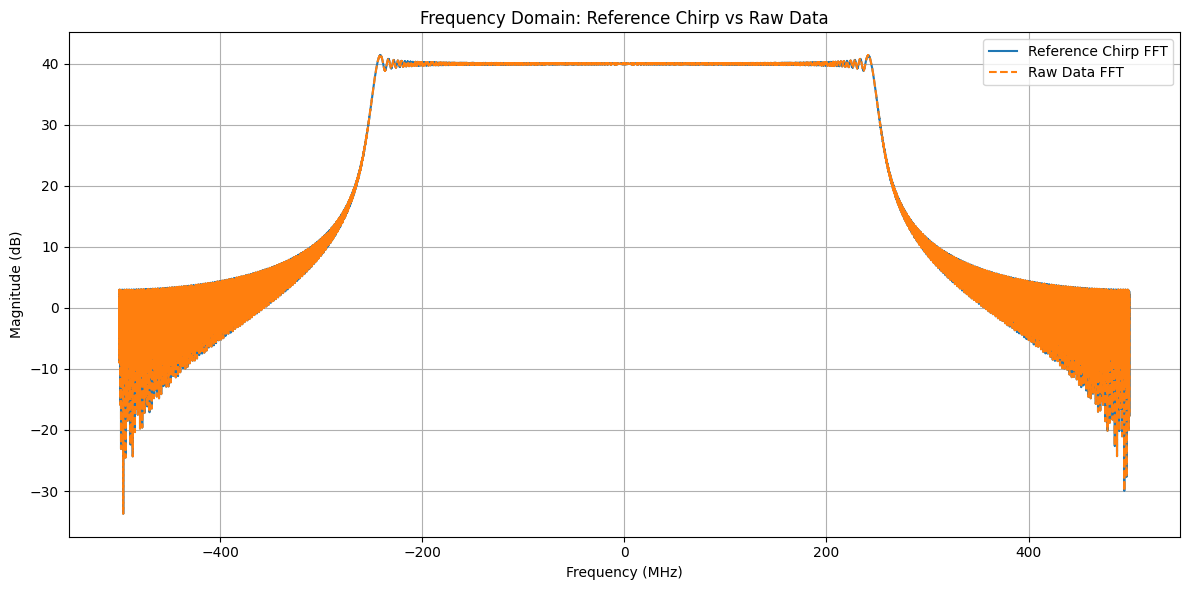

In [80]:
compressed_data = matched_filtering_range_real_chirp(
    raw_data=raw_data_delayed,
    pulse_width=pulse_width,
    bandwidth=bandwidth,
    sampling_frequency=sampling_frequency,
    frequency=3e8 / wavelength,  # centre frequency
    amplitude=1.0
)

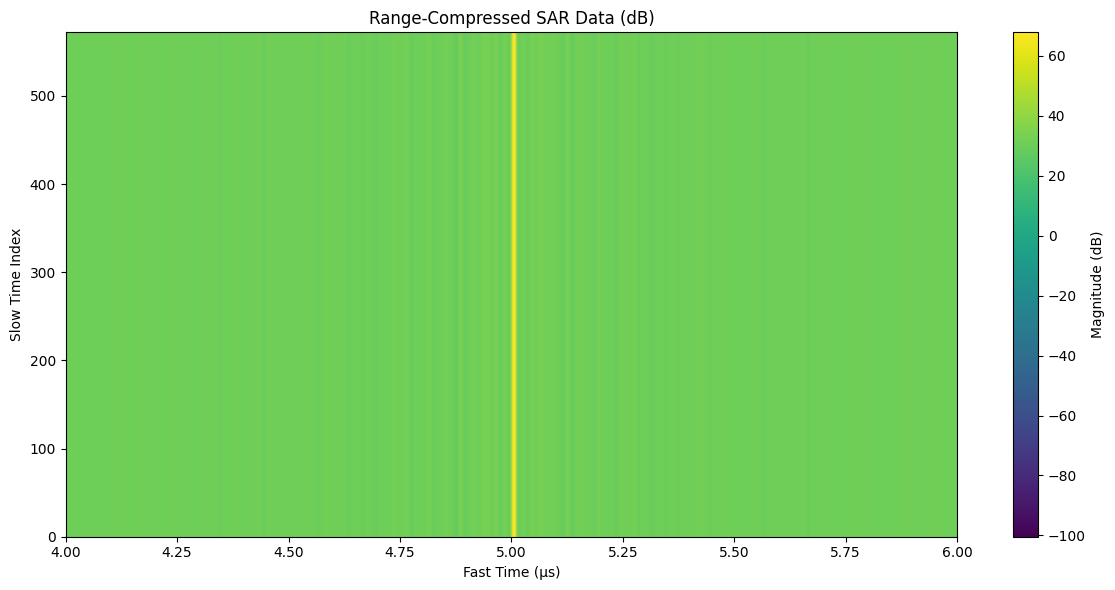

In [85]:
plot_compressed_data_db(
    compressed_data,
    sampling_frequency=sampling_frequency,
    xlim_microseconds=(4, 6),  # Show full range of the window
    downsample_fast=10
)
